In [1]:
import tensorflow as tf
import numpy as np
import sionna as sn
from sionna.phy.utils import PlotBER
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import Model
import importlib
import PA_model
importlib.reload(PA_model)
from PA_model import PAModel, ACPRCalculatorTF
import matplotlib.pyplot as plt

2026-02-23 19:12:42.887630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771866762.914154   70879 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771866762.921846   70879 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771866762.980020   70879 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771866762.980038   70879 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771866762.980040   70879 computation_placer.cc:177] computation placer alr

#### Generate APSK constellation

In [32]:
def generate_custom_64apsk():

    # Ring sizes
    M = [8, 16, 20, 20]

    # Radii
    R1 = 1.0
    R2 = 2.2
    R3 = 3.6
    R4 = 5.2
    radii = [R1, R2, R3, R4]

    # Phase offsets
    offsets = [
        np.pi - np.pi/16,                 # R1
        np.pi + np.pi/8,                  # R2
        np.pi/20 + np.pi/2,               # R3
        np.pi/20 + np.pi/2                # R4
    ]

    constellation = []

    for m, r, offset in zip(M, radii, offsets):
        phases = offset + np.arange(m) * 2*np.pi/m
        points = r * np.exp(1j * phases)
        constellation.append(points)

    constellation = np.concatenate(constellation)

    # Normalize to unit average power
    avg_power = np.mean(np.abs(constellation)**2)
    constellation /= np.sqrt(avg_power)

    return constellation

apsk_64_const = generate_custom_64apsk()

In [33]:
class Modulator(Layer):

    def __init__(self, constellation, trainable, **kwargs):
        super(Modulator,self).__init__(**kwargs)

        # Define the real and imaginary parts of the constellation as trainable variables
        # self.constellation_real = tf.Variable(constellation.real, dtype=tf.float32, trainable=True)
        # self.constellation_imag = tf.Variable(constellation.imag, dtype=tf.float32, trainable=True)
        self.trainable = trainable

        self.constellation_real_init = constellation.real
        self.constellation_imag_init = constellation.imag

    def build(self, input_shape):
        self.constellation_real = self.add_weight(
            name="constellation_real",
            shape=self.constellation_real_init.shape,
            initializer=tf.constant_initializer(self.constellation_real_init),
            trainable=self.trainable
        )
        self.constellation_imag = self.add_weight(
            name="constellation_imag",
            shape=self.constellation_imag_init.shape,
            initializer=tf.constant_initializer(self.constellation_imag_init),
            trainable=self.trainable
        )

    def call(self, s):
        # Combine the real and imaginary parts into a complex-valued constellation
        constellation_combined = tf.complex(self.constellation_real, self.constellation_imag)

        # Expand the signal dimension to align for matrix multiplication
        s = tf.expand_dims(s, axis=-1)

        # Calculate the normalization constant
        normalization_constant = tf.sqrt(
            tf.reduce_mean(tf.abs(constellation_combined) ** 2)
        )

        normalization_constant = tf.complex(normalization_constant,0.0)

        # Normalize the constellation
        norm_constellation = tf.expand_dims(constellation_combined, axis=0)  # Add batch dimension
        norm_constellation = norm_constellation / normalization_constant
        norm_constellation = tf.expand_dims(norm_constellation, axis=0)  # Expand further for batch processing

        # print('norm_constellation:', norm_constellation.shape)

        # Compute the modulated signal
        x_real = tf.matmul(tf.math.real(norm_constellation), s)
        x_imag = tf.matmul(tf.math.imag(norm_constellation), s)
        x = tf.complex(x_real, x_imag)

        return tf.squeeze(x, axis=[-2, -1])

class Demodulator(Layer):
    def __init__(self, N, snr_db):
        super(Demodulator, self).__init__()
        self.dense1 = Dense(128, activation='relu')  # First Dense Layer
        self.dense2 = Dense(128, activation='relu')  # Second Dense Layer
        self.dense3 = Dense(N)                      # Output Dense Layer
        self.snr_db = snr_db                        # SNR in dB
        # self.device = device                        # Device (e.g., "cpu", "gpu")

    def call(self, y):
        # Ensure complex-valued input is split into real and imaginary parts
        y_real = tf.math.real(y)
        y_imag = tf.math.imag(y)

        # Create and broadcast SNR tensor
        snr_tensor = tf.constant([[self.snr_db]], dtype=tf.float32)
        brd_snr_tensor = tf.broadcast_to(snr_tensor, [tf.shape(y_real)[0], 1])

        # Concatenate real, imaginary, and SNR tensors along the last dimension
        stack_input = tf.concat([y_real, y_imag, brd_snr_tensor], axis=1)

        ## print('brd_snr_tensor.shape: ',brd_snr_tensor)

        # Pass the stacked input through the dense layers
        x = self.dense1(stack_input)
        x = self.dense2(x)
        logits = self.dense3(x)

        # Apply softmax to logits
        pred_probs = tf.nn.softmax(logits, axis=-1)

        return pred_probs

class Modulator_SNR(Layer):

    def __init__(self, N, constellation, **kwargs):
        super(Modulator_SNR,self).__init__(**kwargs)

        self.N = N
        # FC layers as requested
        self.dense1 = Dense(128, activation='relu')      # 128 ReLU
        self.dense2 = Dense(128, activation=None)        # 128 Linear
        self.dense_out = Dense(2 * N, activation=None)   # Final projection

        self.dense_out.build(input_shape=(None, 128))
        # self.dense5.build(input_shape=(None, 64))

        self.dense_out.set_weights([
            np.zeros((128, 2 * N), dtype=np.float32),np.concatenate([np.real(constellation), np.imag(constellation)],axis=0)
        ])

    def call(self, snr_db, s):

        # Pass SNR through FC layers
        x = self.dense1(snr_db)
        x = self.dense2(x)
        out = self.dense_out(x)

        # Split into real and imaginary parts
        real = out[:, :self.N]
        imag = out[:, self.N:]
        constellation = tf.complex(real, imag)

        # Normalize to unit average energy
        power = tf.reduce_mean(tf.abs(constellation)**2, axis=1, keepdims=True)
        norm_constellation = constellation / tf.complex(tf.sqrt(power),0.0)

        # Expand the signal dimension to align for matrix multiplication
        s = tf.expand_dims(s, axis=-1)
        norm_constellation = tf.expand_dims(tf.expand_dims(norm_constellation, axis=[1]), axis=[1])

        # Compute the modulated signal
        x_real = tf.matmul(tf.math.real(norm_constellation), s)
        x_imag = tf.matmul(tf.math.imag(norm_constellation), s)
        x = tf.complex(x_real, x_imag)

        return tf.squeeze(x, axis=[-2, -1]), norm_constellation

class Demodulator_SNR(Layer):
    def __init__(self, N):
        super(Demodulator_SNR, self).__init__()
        self.dense1 = Dense(128, activation='relu')  # First Dense Layer
        self.dense2 = Dense(128, activation='relu')  # Second Dense Layer
        self.dense3 = Dense(N)                       # Output Dense Layer
        # self.snr_db = snr_db                       # SNR in dB
        # self.device = device                       # Device (e.g., "cpu", "gpu")

    def call(self, ebno_db, y):

        y = tf.expand_dims(y, axis=-1)
        ebno_db = tf.expand_dims(ebno_db, axis=1)
        # Ensure complex-valued input is split into real and imaginary parts
        y_real = tf.math.real(y)
        y_imag = tf.math.imag(y)

        # Create and broadcast SNR tensor
        # snr_tensor = tf.constant([[self.snr_db]], dtype=tf.float32)
        brd_ebno_db = tf.broadcast_to(ebno_db, [tf.shape(y_real)[0], tf.shape(y_real)[1], 1])

        # Concatenate real, imaginary, and SNR tensors along the last dimension
        stack_input = tf.concat([y_real, y_imag, brd_ebno_db], axis=2)

        # Pass the stacked input through the dense layers
        x = self.dense1(stack_input)
        x = self.dense2(x)
        logits = self.dense3(x)

        # Apply softmax to logits
        pred_probs = tf.nn.softmax(logits, axis=-1)

        return pred_probs

class AWGNDemodulator(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, y, N0, norm_constellation):

        y_exp = tf.expand_dims(y, axis=-1)
        const_exp = tf.reshape(norm_constellation, [y_exp.shape[0], 1, -1])
        dist2 = tf.abs(y_exp - const_exp) ** 2   # (B, T, N)
        log_probs = -dist2 / tf.expand_dims(N0, axis=1)
        p_xy = tf.nn.softmax(log_probs, axis=-1)

        return p_xy
class NeuralDPD(Model):
    def __init__(self, L=5, hidden_units=64):
        super(NeuralDPD, self).__init__()

        self.L = L
        self.input_dim = 7 * L   # I, Q, abs, square, cubic

        self.fc1 = Dense(hidden_units, activation='tanh')
        self.fc2 = Dense(2, activation=None)   # I_out, Q_out

    def call(self, inputs):
        """
        inputs shape: (batch, 5*L)
        """
        x = self.fc1(inputs)
        out = self.fc2(x)
        return out


def create_features_window(iq_signal, L):
    """
    iq_signal: (batch, T) complex
    return:    (batch, T, 7*L)
    """

    batch, T = iq_signal.shape

    # ----- 1) prepend zeros -----
    pad = tf.zeros((batch, L-1), dtype=iq_signal.dtype)
    x_pad = tf.concat([pad, iq_signal], axis=1)   # (batch, T+L-1)

    I = tf.math.real(x_pad)
    Q = tf.math.imag(x_pad)

    # Odd-order basis functions, I and Q
    abs_x = tf.abs(x_pad)
    # sq_x  = abs_x ** 2
    cube_x = abs_x ** 3
    fifth_x = abs_x ** 5
    seventh_x = abs_x ** 7
    nineth_x = abs_x ** 9

    features = []

    # ----- 2) sliding window -----
    for n in range(T):

        # window n : n → n+L
        Iw = I[:, n:n+L]
        Qw = Q[:, n:n+L]
        Aw = abs_x[:, n:n+L]
        Cw3 = cube_x[:, n:n+L]
        Cw5 = fifth_x[:, n:n+L]
        Cw7 = seventh_x[:, n:n+L]
        Cw9 = nineth_x[:, n:n+L]

        # concatenate the 5 groups
        fn = tf.concat([Iw, Qw, Aw, Cw3, Cw5, Cw7, Cw9], axis=1)  # (batch, 7L)

        features.append(fn)

    # ----- 3) stack over time -----
    features = tf.stack(features, axis=1)  # (batch, T, 7L)

    return features


class EndToEndSystem(Model):
    def __init__(self, dpd_weights_file, N, constellation, snr_db, batch_size, stream_size, Pin, run_ber, with_dpd, const_trainable):
        super(EndToEndSystem, self).__init__()
        self.batch_size = batch_size
        self.stream_size = stream_size
        self.N = N
        # self.No = 1/(10**(snr_db/10))
        # self.sampling = SamplingMechanism(N, tau, snr_db, batch_size, device)
        # self.modulator = Modulator(constellation, const_trainable)
        self.modulator = Modulator_SNR(N,constellation)

        self.channel = sn.phy.channel.AWGN()
        # self.demodulator = Demodulator(N, snr_db)
        # self.demodulator = Demodulator_SNR(N)

        self.awgndemodulator = AWGNDemodulator()
        self.loss_fn = CategoricalCrossentropy(from_logits=False)

        self.upsampler = sn.phy.signal.Upsampling(samples_per_symbol=4)
        self.tx_filter = sn.phy.signal.RootRaisedCosineFilter(beta=0.3,
                                                         samples_per_symbol=4,
                                                         span_in_symbols=32)
        self.rx_filter = sn.phy.signal.RootRaisedCosineFilter(beta=0.3,
                                                         samples_per_symbol=4,
                                                         span_in_symbols=32)
        self.downsampler = sn.phy.signal.Downsampling(samples_per_symbol=4,
                                                      offset = self.rx_filter.length - 1,
                                                 num_symbols=tf.cast(self.stream_size, tf.int32))
        self.run_ber = run_ber
        self.with_dpd = with_dpd
        f0 = 10e9
        Fs = 5e8
        self.pa_model = PAModel(Fs,f0)
        self.L = 5
        self.dpd_model = NeuralDPD(L=self.L , hidden_units=32)
        self.dpd_model(tf.zeros([1, 35]))
        self.dpd_model.load_weights(dpd_weights_file)
        self.dpd_model.trainable = False
        self.Pin = Pin
        # self.overall_gain = 68.546 * tf.pow(10.0, (Pin-9)/20.0)
        self.overall_gain = 84.9511

        self.acpr_obj = ACPRCalculatorTF()
        self.fs_input = 400000000.0 # This is Symbol_rate * Upsample factor
        self.f0_bb_input = 0.0
        self.meas_bw_main_input = 100000000.0 # This is Symbol_rate
        self.acpr_offsets_input = [100000000.0*(1+0.3)*0.9] # 0.3 is the roll-off factor
        self.meas_bw_acpr_input = 100000000.0 # This is Symbol_rate

    def build(self, input_shape=None):
        self.built = True
        super().build(input_shape)

    @tf.function
    def call(self, batch_size, ebno_db):
        # tf.print("Executing eagerly:", tf.executing_eagerly())
        if self.run_ber:
            ebno_db = tf.reshape(ebno_db, [1, 1])
            ebno_db = tf.tile(ebno_db, [batch_size, 1])
        else:
            ebno_db = tf.expand_dims(ebno_db, axis = 1)
        No = sn.phy.utils.ebnodb2no(ebno_db, num_bits_per_symbol=6, coderate=1)
        symbol_index_seq = tf.random.uniform(shape=(self.batch_size,self.stream_size), minval=0, maxval=64, dtype=tf.int32)
        s = tf.one_hot(symbol_index_seq, depth=self.N, dtype=tf.float32)

        # Modulate the symbols
        x_mod, norm_constel = self.modulator(ebno_db, s)
        # rms_x_mod = tf.sqrt(tf.reduce_mean(tf.abs(x_mod) ** 2))
        # print('rms_x_mod :',rms_x_mod)

        if self.with_dpd:
            x_up = self.upsampler(x_mod)
            # rms_x_up = tf.sqrt(tf.reduce_mean(tf.abs(x_up) ** 2))
            # print('rms_x_up :',rms_x_up)
            x_tx_filt = self.tx_filter(x_up)

            # DPD in
            feats = create_features_window(x_tx_filt, self.L)
            dpd_out = self.dpd_model(feats)
            dpd_complex = tf.complex(
                dpd_out[...,0],
                dpd_out[...,1]
            )
            rms_dpd = tf.sqrt(tf.reduce_mean(tf.abs(dpd_complex) ** 2))
            Gain = tf.complex(tf.pow(10.0, self.Pin / 20.0) / rms_dpd,0.0)
            # print(Gain)
            # print('rms_dpd :',rms_dpd)
            # DPD out
            xin = tf.squeeze(Gain * dpd_complex)
            # rms_xin = tf.sqrt(tf.reduce_mean(tf.abs(xin) ** 2))
            # print('rms_xin :',rms_xin)
            pa_out = self.pa_model.forward_differentiable(xin)
            # rms_pa_out= tf.sqrt(tf.reduce_mean(tf.abs(pa_out) ** 2))
            # print('rms_pa_out :',rms_pa_out)
            y_channel = self.channel(pa_out, No*(self.overall_gain)**2)
            # print('y_channel :',y_channel[0,128:150])
            # y_channel_norm = y_channel/9.54
            # print('y_channel_norm :',y_channel_norm[0,128:150])
            # y_channel = pa_out # Assumption that there is no channel??
            y_rx_filt = self.rx_filter(y_channel)
            # print('y_rx_filt :',y_rx_filt[0,128:150])
            y = self.downsampler(y_rx_filt)
            # print(y.shape)
            # print('y :',y[0,128:150])
        else:
            x_up = self.upsampler(x_mod)
            x_tx_filt = self.tx_filter(x_up)
            # DPD in
            # rms_x = tf.sqrt(tf.reduce_mean(tf.abs(x_tx_filt) ** 2))
            # Gain = tf.complex(tf.pow(10.0, 9 / 20.0) / rms_x,0.0)
            # xin = tf.squeeze(Gain * x_tx_filt)
            # pa_out = self.pa_model.forward_differentiable(xin)
            # tf.print(x_tx_filt.dtype, No.dtype)
            # feats = create_features_window(x_tx_filt, self.L)
            y_channel = self.channel(x_tx_filt, No)
            # y_channel = pa_out # Assumption that there is no channel??
            y_rx_filt = self.rx_filter(y_channel)
            # y = self.downsampler(y_rx_filt)


        # Demodulate the received signal
        ####### Neural demodulator #############
        # print('y rms: ',tf.sqrt(tf.reduce_mean(tf.abs(y)**2)))  # 68.546 for Pin = 9 and zero noise (PA is linearized well)
        y_norm = y/tf.complex(self.overall_gain,0.0)
        # y_norm = y/tf.complex(tf.sqrt(tf.reduce_mean(tf.abs(y)**2)),0.0)
        # y_combined_dim = tf.reshape(y_norm, [self.batch_size * self.stream_size,1])
        # pred_probs = self.demodulator(ebno_db, y_norm)
        pred_probs = self.awgndemodulator(y_norm, No, norm_constel)
        # pred_probs = tf.reshape(pred_probs_combined_dim, [self.batch_size, self.stream_size, self.N])
        #######  MAP demodulator ##############
        # pred_probs = self.awgndemodulator(y)
        #######################################

        if self.run_ber:
            x_hat = tf.argmax(pred_probs, axis=-1, output_type=tf.int32)
            return symbol_index_seq, x_hat
        else:
            loss = self.loss_fn(s,pred_probs)
            return loss, norm_constel, pa_out, x_tx_filt  #, norm_constel, y_norm, No, x_mod


    # @tf.function
    def compute_power_to_average_power_samples(self,ebno_db):
        if self.run_ber:
            ebno_db = tf.reshape(ebno_db, [1, 1])
            ebno_db = tf.tile(ebno_db, [self.batch_size, 1])
        else:
            ebno_db = tf.expand_dims(ebno_db, axis = 1)
        symbol_index_seq = tf.random.uniform(shape=(self.batch_size,self.stream_size), minval=0, maxval=64, dtype=tf.int32)
        s_power = tf.one_hot(symbol_index_seq, depth=self.N, dtype=tf.float32)
        x_mod_power,_ = self.modulator(ebno_db, s_power)
        x_up_power = self.upsampler(x_mod_power)
        x_tx_filt_power = self.tx_filter(x_up_power)
        p_x = tf.square(tf.abs(x_tx_filt_power))
        power_samples = p_x / tf.reduce_mean(p_x)
        return power_samples

    # @tf.function
    def compute_evm(self):
        symbol_index_seq = tf.random.uniform(shape=(self.batch_size,self.stream_size), minval=0, maxval=64, dtype=tf.int32)
        s = tf.one_hot(symbol_index_seq, depth=self.N, dtype=tf.float32)
        x_mod,_ = self.modulator(s)
        x_up = self.upsampler(x_mod)
        x_tx_filt = self.tx_filter(x_up)
        feats = create_features_window(x_tx_filt, self.L)
        dpd_out = self.dpd_model(feats)
        dpd_complex = tf.complex(
            dpd_out[...,0],
            dpd_out[...,1]
        )
        rms_dpd = tf.sqrt(tf.reduce_mean(tf.abs(dpd_complex) ** 2))
        Gain = tf.complex(tf.pow(10.0, self.Pin / 20.0) / rms_dpd,0.0)
        xin = tf.squeeze(Gain * dpd_complex)
        pa_out = self.pa_model.forward_differentiable(xin)

        y_rx_filt = self.rx_filter(pa_out)
        y = self.downsampler(y_rx_filt)

        phase = tf.math.angle(tf.reduce_sum(x_mod * tf.math.conj(y)))

        y_values = y * tf.exp(-1j * tf.cast(-phase, tf.complex64))

        y_norm = y_values/tf.complex(tf.sqrt(tf.reduce_mean(tf.abs(y_values)**2)),0.0)

        x_mod_values = x_mod/tf.complex(tf.sqrt(tf.reduce_mean(tf.abs(x_mod)**2)),0.0)

        error = y_norm - x_mod_values

        # ---- RMS EVM (ratio)
        evm_rms = tf.sqrt(
            tf.reduce_sum(tf.abs(error)**2) /
            tf.reduce_sum(tf.abs(x_mod_values)**2)
        )

        evm_dB = 20*tf.math.log(evm_rms)/tf.math.log(10.0);

        # acpr1_val, acpr2_val, ChP_val = \
        #     self.acpr_obj.calculate_acpr_sur(pa_out,self.fs_input,\
        #     self.f0_bb_input,self.meas_bw_main_input,self.acpr_offsets_input,self.meas_bw_acpr_input)
        return evm_dB


### PAPR Plot

In [7]:
N = 64  # Number of classes (symbols)

# 16QAM constellation points
real_values = [-7, -5, -3, -1, 1, 3, 5, 7]  # Real part values
imag_values = [-7, -5, -3, -1, 1, 3, 5, 7]  # Imaginary part values
# Generate the 64QAM constellation
constellation = np.array([(x + 1j * y) for x in real_values for y in imag_values])
# Compute average energy
Es = np.mean(np.abs(constellation)**2)
# Normalize
constellation = constellation / np.sqrt(Es)

snr_db = 12  # SNR in dB
Pin = 15

# Batch size
batch_size = 40
stream_size = 40960

device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
weights_file = "dpd_trained_overdrive15.weights.h5"

model = EndToEndSystem(weights_file, N, constellation, snr_db, batch_size, stream_size, Pin, run_ber=False, with_dpd=True, const_trainable=True)
            # dpd_weights_file, N, constellation, snr_db, batch_size, stream_size, Pin, run_ber, with_dpd, const_trainable

ebno_db = tf.random.uniform(shape=[batch_size], minval=31.0, maxval=32.0)
# No = sn.phy.utils.ebnodb2no(ebno_db, num_bits_per_symbol=6, coderate=1)

# symbol_index_seq, x_hat = model(batch_size = batch_size, ebno_db = ebno_db)

powers = tf.reshape(
    model.compute_power_to_average_power_samples(ebno_db), [-1]
)
powers_db = 10 * tf.math.log(powers + 1e-12) / tf.math.log(10.)

x_sorted = np.sort(powers_db.numpy())
ccdf = 1.0 - np.arange(1, len(x_sorted) + 1) / len(x_sorted)

In [44]:
for v in model.trainable_weights:
    print(v.path, v.shape)

end_to_end_system_3/modulator_3/constellation_real (64,)
end_to_end_system_3/modulator_3/constellation_imag (64,)
end_to_end_system_3/demodulator_3/dense_15/kernel (3, 128)
end_to_end_system_3/demodulator_3/dense_15/bias (128,)
end_to_end_system_3/demodulator_3/dense_16/kernel (128, 128)
end_to_end_system_3/demodulator_3/dense_16/bias (128,)
end_to_end_system_3/demodulator_3/dense_17/kernel (128, 64)
end_to_end_system_3/demodulator_3/dense_17/bias (64,)


In [34]:
evm = model.compute_evm()
evm.numpy()

-43.07771

In [19]:
N = 64  # Number of classes (symbols)

constellation = apsk_64_const

Es = np.mean(np.abs(constellation)**2)
# Normalize
constellation = constellation / np.sqrt(Es)

snr_db = 12  # SNR in dB
Pin = 15

# Batch size
batch_size = 40
stream_size = 40960

device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
weights_file = "dpd_trained_overdrive15.weights.h5"

model = EndToEndSystem(weights_file, N, constellation, snr_db, batch_size, stream_size, Pin, run_ber=False, with_dpd=True, const_trainable=True)
            # dpd_weights_file, N, constellation, snr_db, batch_size, stream_size, Pin, run_ber, with_dpd, const_trainable

ebno_db = tf.random.uniform(shape=[batch_size], minval=31.0, maxval=32.0)
No = sn.phy.utils.ebnodb2no(ebno_db, num_bits_per_symbol=6, coderate=1)

# symbol_index_seq, x_hat = model(batch_size = batch_size, ebno_db = ebno_db)

powers = tf.reshape(
    model.compute_power_to_average_power_samples(ebno_db), [-1]
)
powers_db = 10 * tf.math.log(powers + 1e-12) / tf.math.log(10.)

x_sorted1 = np.sort(powers_db.numpy())
ccdf1 = 1.0 - np.arange(1, len(x_sorted1) + 1) / len(x_sorted1)

In [10]:
N = 64  # Number of classes (symbols)

constellation = apsk_64_const

Es = np.mean(np.abs(constellation)**2)
# Normalize
constellation = constellation / np.sqrt(Es)

snr_db = 12  # SNR in dB
Pin = 15

# Batch size
batch_size = 10
stream_size = 256

device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
weights_file = "dpd_trained_overdrive15.weights.h5"

model = EndToEndSystem(weights_file, N, constellation, snr_db, batch_size, stream_size, Pin, run_ber=False, with_dpd=True, const_trainable=True)

ebno_db = tf.random.uniform(shape=[batch_size], minval=31.0, maxval=32.0)
No = sn.phy.utils.ebnodb2no(ebno_db, num_bits_per_symbol=6, coderate=1)

_, _, _, _ = model(batch_size = batch_size, ebno_db = ebno_db)

model.load_weights("model_pin15_ADC_demapper.weights.h5")

new_batch_size = 40

model.batch_size = new_batch_size
model.stream_size = 40960



In [11]:
ebno_db = tf.random.uniform(shape=[new_batch_size], minval=8.0-0.781513, maxval=8.1-0.781513)

powers = tf.reshape(
    model.compute_power_to_average_power_samples(ebno_db), [-1]
)
powers_db = 10 * tf.math.log(powers + 1e-12) / tf.math.log(10.)

x_sorted2 = np.sort(powers_db.numpy())
ccdf2 = 1.0 - np.arange(1, len(x_sorted2) + 1) / len(x_sorted2)

In [12]:
ebno_db = tf.random.uniform(shape=[new_batch_size], minval=22.0-0.781513, maxval=22.1-0.781513)

powers = tf.reshape(
    model.compute_power_to_average_power_samples(ebno_db), [-1]
)
powers_db = 10 * tf.math.log(powers + 1e-12) / tf.math.log(10.)

x_sorted3 = np.sort(powers_db.numpy())
ccdf3 = 1.0 - np.arange(1, len(x_sorted3) + 1) / len(x_sorted3)

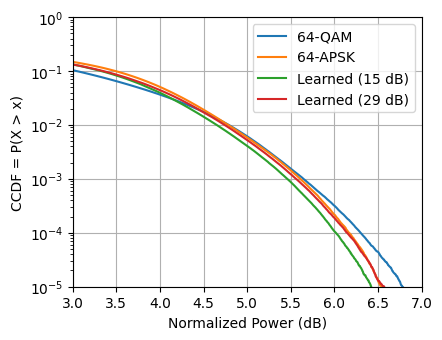

In [21]:
plt.figure(figsize=[4.5, 3.5])
plt.plot(x_sorted, ccdf,label="64-QAM")
plt.plot(x_sorted1, ccdf1,label="64-APSK")
plt.plot(x_sorted2, ccdf2,label="Learned (15 dB)")
plt.plot(x_sorted3, ccdf3,label="Learned (29 dB)")
# plt.plot(x_sorted4, ccdf4,label="Learned - Pin = 18")
# plt.plot(x_sorted4, ccdf4)
plt.xlabel("Normalized Power (dB)")
plt.xlim(3,7)
plt.ylabel("CCDF = P(X > x)")
plt.yscale("log")   # optional, very common
plt.grid(True)
plt.ylim(1e-5, 1)
plt.legend(loc='upper right')
plt.show()

### ACLR Plot

In [13]:
acpr_obj = ACPRCalculatorTF()
fs_input = 400000000.0 # This is Symbol_rate * Upsample factor
f0_bb_input = 0.0
meas_bw_main_input = 100000000.0 # This is Symbol_rate
acpr_offsets_input = [100000000.0*(1+0.3)*0.9] # 0.3 is the roll-off factor
meas_bw_acpr_input = 100000000.0 # This is Symbol_rate

In [ ]:
N = 64  # Number of classes (symbols)

Pin = 15
snr_db = 12

# Batch size
batch_size = 400
stream_size = 256

device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"

weights_file = "dpd_trained_overdrive15.weights.h5"

In [14]:
constellation = apsk_64_const

Es = np.mean(np.abs(constellation)**2)
constellation = constellation / np.sqrt(Es)

model = EndToEndSystem(weights_file, N, constellation, snr_db, batch_size, stream_size, Pin, run_ber =False, with_dpd=True, const_trainable = True)

ebno_db = tf.random.uniform(shape=[batch_size], minval=8.0, maxval=8.1)
_, _, pa_out_values, filter_out = model(batch_size = batch_size, ebno_db = ebno_db, training = False)

filterout_rms = np.sqrt(tf.reduce_mean(tf.square(tf.abs(filter_out))).numpy())

f_plot, Pxx_plot = acpr_obj.welch_tf(
    pa_out_values*812.699, fs_input, nperseg=512, noverlap=0  # print(filter_out.shape) (10, 1152) sqrt(10*1152) = 107.33
)
# _, Pxx_filter_out = acpr_obj.welch_tf(
#     filter_out*812.699/filterout_rms, fs_input, nperseg=512, noverlap=0
# )

In [17]:
# # 16QAM constellation points
real_values = [-7, -5, -3, -1, 1, 3, 5, 7]  # Real part values
imag_values = [-7, -5, -3, -1, 1, 3, 5, 7]  # Imaginary part values
# # Generate the 64QAM constellation
constellation = np.array([(x + 1j * y) for x in real_values for y in imag_values])

Es = np.mean(np.abs(constellation)**2)
constellation = constellation / np.sqrt(Es)

model = EndToEndSystem(weights_file, N, constellation, snr_db, batch_size, stream_size, Pin, run_ber =False, with_dpd=True, const_trainable = True)

ebno_db = tf.random.uniform(shape=[batch_size], minval=8.0, maxval=8.1)
_, _, pa_out_values, filter_out = model(batch_size = batch_size, ebno_db = ebno_db, training = False)

filterout_rms = np.sqrt(tf.reduce_mean(tf.square(tf.abs(filter_out))).numpy())

_, Pxx_plot1 = acpr_obj.welch_tf(
    pa_out_values*812.699, fs_input, nperseg=512, noverlap=0  # print(filter_out.shape) (10, 1152) sqrt(10*1152) = 107.33
)
# _, _ = acpr_obj.welch_tf(
#     filter_out*812.699/filterout_rms, fs_input, nperseg=512, noverlap=0
# )

In [23]:
# # 16QAM constellation points
real_values = [-7, -5, -3, -1, 1, 3, 5, 7]  # Real part values
imag_values = [-7, -5, -3, -1, 1, 3, 5, 7]  # Imaginary part values
# # Generate the 64QAM constellation
constellation = np.array([(x + 1j * y) for x in real_values for y in imag_values])

Es = np.mean(np.abs(constellation)**2)
constellation = constellation / np.sqrt(Es)

model = EndToEndSystem(weights_file, N, constellation, snr_db, batch_size, stream_size, Pin, run_ber =False, with_dpd=True, const_trainable = True)

ebno_db = tf.random.uniform(shape=[batch_size], minval=8.0, maxval=8.1)
_, _, _, _ = model(batch_size = batch_size, ebno_db = ebno_db, training = False)

model.load_weights("model_pin15_ADC_demapper.weights.h5")

ebno_db = tf.random.uniform(shape=[batch_size], minval=8.0-0.781513, maxval=8.1-0.781513)
_, _, pa_out_values, filter_out = model(batch_size = batch_size, ebno_db = ebno_db, training = False)

filterout_rms = np.sqrt(tf.reduce_mean(tf.square(tf.abs(filter_out))).numpy())

_, Pxx_plot2 = acpr_obj.welch_tf(
    pa_out_values*812.699, fs_input, nperseg=512, noverlap=0  # print(filter_out.shape) (10, 1152) sqrt(10*1152) = 107.33
)


ebno_db = tf.random.uniform(shape=[batch_size], minval=22.0-0.781513, maxval=22.1-0.781513)
_, _, pa_out_values, filter_out = model(batch_size = batch_size, ebno_db = ebno_db, training = False)

filterout_rms = np.sqrt(tf.reduce_mean(tf.square(tf.abs(filter_out))).numpy())

_, Pxx_plot3 = acpr_obj.welch_tf(
    pa_out_values*812.699, fs_input, nperseg=512, noverlap=0  # print(filter_out.shape) (10, 1152) sqrt(10*1152) = 107.33
)

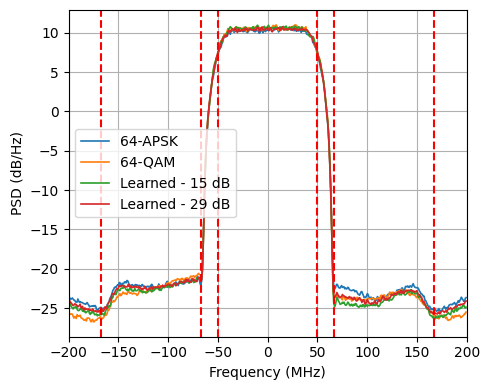

In [31]:
# Convert TensorFlow tensors → NumPy
f = f_plot.numpy()
Pxx = Pxx_plot.numpy()
Pxx1 = Pxx_plot1.numpy()
Pxx2 = Pxx_plot2.numpy()
Pxx3 = Pxx_plot3.numpy()

# Convert to dB/Hz
Pxx_dB = 10 * np.log10(np.abs(Pxx) + 1e-30)
Pxx1_dB = 10 * np.log10(np.abs(Pxx1) + 1e-30)
Pxx2_dB = 10 * np.log10(np.abs(Pxx2) + 1e-30)
Pxx3_dB = 10 * np.log10(np.abs(Pxx3) + 1e-30)

plt.figure(figsize=(5, 4))
plt.plot(f / 1e6, Pxx_dB, linewidth=1.2,label="64-APSK")
plt.plot(f / 1e6, Pxx1_dB, linewidth=1.2,label="64-QAM")
plt.plot(f / 1e6, Pxx2_dB, linewidth=1.2,label="Learned - 15 dB")
plt.plot(f / 1e6, Pxx3_dB, linewidth=1.2,label="Learned - 29 dB")

plt.xlabel("Frequency (MHz)")
plt.ylabel("PSD (dB/Hz)")
plt.xlim([-200,200])
# plt.title("Power Spectral Density")

plt.axvline(x=(acpr_offsets_input[0] - meas_bw_main_input/2)/1e6 , linestyle = "--", color = "red")
plt.axvline(x=(acpr_offsets_input[0] + meas_bw_main_input/2)/1e6 , linestyle = "--", color = "red")

plt.axvline(x=(-acpr_offsets_input[0] - meas_bw_main_input/2)/1e6 , linestyle = "--", color = "red")
plt.axvline(x=(-acpr_offsets_input[0] + meas_bw_main_input/2)/1e6 , linestyle = "--", color = "red")

plt.axvline(x=(- meas_bw_main_input/2)/1e6 , linestyle = "--", color = "red")
plt.axvline(x=(meas_bw_main_input/2)/1e6 , linestyle = "--", color = "red")
plt.grid(True)
plt.legend(loc='center left')
plt.tight_layout()
plt.show()

### Training Function

In [8]:
N = 64  # Number of classes (symbols)

# # 16QAM constellation points
# real_values = [-7, -5, -3, -1, 1, 3, 5, 7]  # Real part values
# imag_values = [-7, -5, -3, -1, 1, 3, 5, 7]  # Imaginary part values
# # Generate the 64QAM constellation
# constellation = np.array([(x + 1j * y) for x in real_values for y in imag_values])

constellation = apsk_64_const

# Compute average energy
Es = np.mean(np.abs(constellation)**2)
# Normalize
constellation = constellation / np.sqrt(Es)

snr_db = 12  # SNR in dB
# No = 1/(10**(snr_db/10))

Pin = 15

# Batch size
batch_size = 10
stream_size = 256

device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"

weights_file = "dpd_trained_overdrive15.weights.h5"

model = EndToEndSystem(weights_file, N, constellation, snr_db, batch_size, stream_size, Pin, run_ber=False, with_dpd=True, const_trainable=True)

In [37]:
ebno_db = tf.random.uniform(shape=[1], minval=30.0, maxval=31.0)
# No = sn.phy.utils.ebnodb2no(ebno_db, num_bits_per_symbol=6, coderate=1)
indices, estimate = model(batch_size=batch_size, ebno_db=ebno_db)

In [9]:
ebno_db = tf.random.uniform(shape=[10], minval=30.0, maxval=30.2)
_, _= model(batch_size = 10, ebno_db = ebno_db)

I0000 00:00:1771830720.413230   21553 cuda_dnn.cc:529] Loaded cuDNN version 91400


In [26]:
indices[0,:20]

<tf.Tensor: shape=(20,), dtype=int32, numpy=
array([26, 15,  9, 31,  0,  8, 26, 25, 48, 26, 10, 39, 12, 42, 12,  7, 60,
        4, 26, 21], dtype=int32)>

In [27]:
estimate[0,:20]

<tf.Tensor: shape=(20,), dtype=int32, numpy=
array([21,  4,  1,  9,  0,  1, 21, 20, 28, 21,  2, 15,  3, 18,  3,  7, 40,
        4, 21,  7], dtype=int32)>

In [213]:
for v in model.trainable_weights:
    print(v.path, v.shape)

end_to_end_system_24/modulator_snr_53/dense_333/kernel (1, 128)
end_to_end_system_24/modulator_snr_53/dense_333/bias (128,)
end_to_end_system_24/modulator_snr_53/dense_334/kernel (128, 128)
end_to_end_system_24/modulator_snr_53/dense_334/bias (128,)
dense_335/kernel (128, 128)
dense_335/bias (128,)


In [123]:
###############################
# Train function
###############################
N = 64
num_bits_symbol = np.log2(N)

use_upsampling_filtering = True
uniform_input = True

# We define a new optimizer at every rune
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# @tf.function
def train_step(lambd_evm, mu):

    with tf.GradientTape() as tape:

        ebno_db = tf.random.uniform([batch_size], 8.0, 30.0)

        # No = sn.phy.utils.ebnodb2no(
        #     ebno_db,
        #     num_bits_per_symbol=num_bits_symbol,
        #     coderate=1
        # )
        # No = tf.expand_dims(No, axis=-1)

        loss, pa_output,_ = model(batch_size=batch_size,ebno_db = ebno_db)

        # evm_db = model.compute_evm()
        #
        # excess_evm = evm_db - (-33)
        # excess_evm = tf.maximum(excess_evm, lambd_evm / mu)

        L = loss # - lambd_evm * excess_evm + 0.5 * mu * tf.square(excess_evm)

    grads = tape.gradient(L, model.trainable_weights)
    grads, _ = tf.clip_by_global_norm(grads, 0.1)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return loss, pa_output


## Inner loop
@tf.function
def _inner_loop(lambd_evm, mu, step, num_it):

    L = 0.0

    k = tf.constant(0, tf.int32)
    while tf.less(k, num_it):
        loss, pa_output = train_step(lambd_evm, mu)

        # tf.print('test 3')
        # Print progress
        if k % 50 == 0:
          tf.print('Iteration',k, 'loss', loss / np.log(2))

        k = k + 1
        step = step + 1

        # tf.print('test 4')

    # evm_db = model.compute_evm()
    # excess_evm = evm_db - (-33)
    # excess_evm = tf.maximum(excess_evm, lambd_evm / mu)

        # tf.print('test 5')

    return step#, excess_evm

# Outer-loop
# Lagrange multiplier
lambd_evm = tf.Variable(tf.constant(0.0, tf.float32), trainable=False, dtype=tf.float32)

# Penalty parameter
mu = tf.Variable(0.01, trainable=False, dtype=tf.float32)

step = tf.constant(0, tf.int32)
for i in range(1):

    # Find a local minimizer (increase the first number of iterations if using random initializations)
    if i == 0:
        num_it = 10000
    else:
        num_it = 35
    # num_it = 500
    # c_excess_power, step = _inner_loop(lambd_papr, mu, step, num_it)
    # tf.print('test 0')
    step  = _inner_loop(lambd_evm, mu, step, num_it)
    tf.print('-------------------------------------------------------')
    tf.print('-------------------------------------------------------')
    tf.print('Progress :',i)
    # tf.print('Progress :',i, 'Excess EVM: ', excess_evm, 'lambda EVM: ', lambd_evm)
    tf.print('-------------------------------------------------------')
    tf.print('-------------------------------------------------------')
    # Update Lagrange multipliers
    # tf.print('c_excess_power',c_excess_power,'lambd_papr',lambd_papr)
    # if i == 0:
    # lambd_evm = lambd_evm - mu * excess_evm

    # Update penalty parameter
    # mu = 1.01 * mu

Iteration 0 loss 0.0729910359
Iteration 50 loss 0.238716349
Iteration 100 loss 0.338112324
Iteration 150 loss 0.232068092
Iteration 200 loss 0.247690931
Iteration 250 loss 0.273427397
Iteration 300 loss 0.193238392
Iteration 350 loss 0.0239886753
Iteration 400 loss 0.0589451
Iteration 450 loss 0.243627176
Iteration 500 loss 0.122610062
Iteration 550 loss 0.0345453769
Iteration 600 loss 0.179511011
Iteration 650 loss 0.178133175
Iteration 700 loss 0.0031840296
Iteration 750 loss 0.346679688
Iteration 800 loss 0.217333034
Iteration 850 loss 0.0631207749
Iteration 900 loss 0.0751591772
Iteration 950 loss 0.18242155
Iteration 1000 loss 0.149871781
Iteration 1050 loss 0.149396747
Iteration 1100 loss 0.12343242
Iteration 1150 loss 0.189156026
Iteration 1200 loss 0.122897595
Iteration 1250 loss 0.252212852
Iteration 1300 loss 0.0842266
Iteration 1350 loss 0.135285661
Iteration 1400 loss 0.0241458211
Iteration 1450 loss 0.0918662846
Iteration 1500 loss 0.0722105503
Iteration 1550 loss 0.016749

In [124]:
model.save_weights("model_pin15_ADC_demapper.weights.h5")

In [56]:
model.load_weights("model_pin15_ADC_demapper.weights.h5")

In [30]:
ber_plot_bicm = PlotBER("BER Performance")

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      7.0 | 3.1445e-01 | 1.0000e+00 |         805 |        2560 |           10 |          10 |        15.3 |reached target bit errors
      8.0 | 2.4766e-01 | 1.0000e+00 |         634 |        2560 |           10 |          10 |         0.1 |reached target bit errors
      9.0 | 1.9453e-01 | 1.0000e+00 |         498 |        2560 |           10 |          10 |         0.1 |reached target bit errors
     10.0 | 1.2266e-01 | 1.0000e+00 |         314 |        2560 |           10 |          10 |         0.1 |reached target bit errors
     11.0 | 8.0859e-02 | 1.0000e+00 |         207 |        2560 |           10 |          10 |         0.1 |reached target bit errors
     12.0 | 4.8438e-02 | 1.0000e+00 |         124 |        2560 |          

(<tf.Tensor: shape=(18,), dtype=float32, numpy=
 array([3.1445312e-01, 2.4765626e-01, 1.9453125e-01, 1.2265625e-01,
        8.0859378e-02, 4.8437499e-02, 3.1054687e-02, 1.5494792e-02,
        6.1523439e-03, 1.9726562e-03, 6.8696123e-04, 2.1081349e-04,
        7.1674309e-05, 4.2321237e-05, 3.5156248e-05, 2.3046876e-05,
        2.6953125e-05, 2.7343751e-05], dtype=float32)>,
 <tf.Tensor: shape=(18,), dtype=float32, numpy=
 array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.8       , 0.375     ,
        0.16034482, 0.05132275, 0.01779816, 0.01040087, 0.0083    ,
        0.0056    , 0.0068    , 0.0068    ], dtype=float32)>)

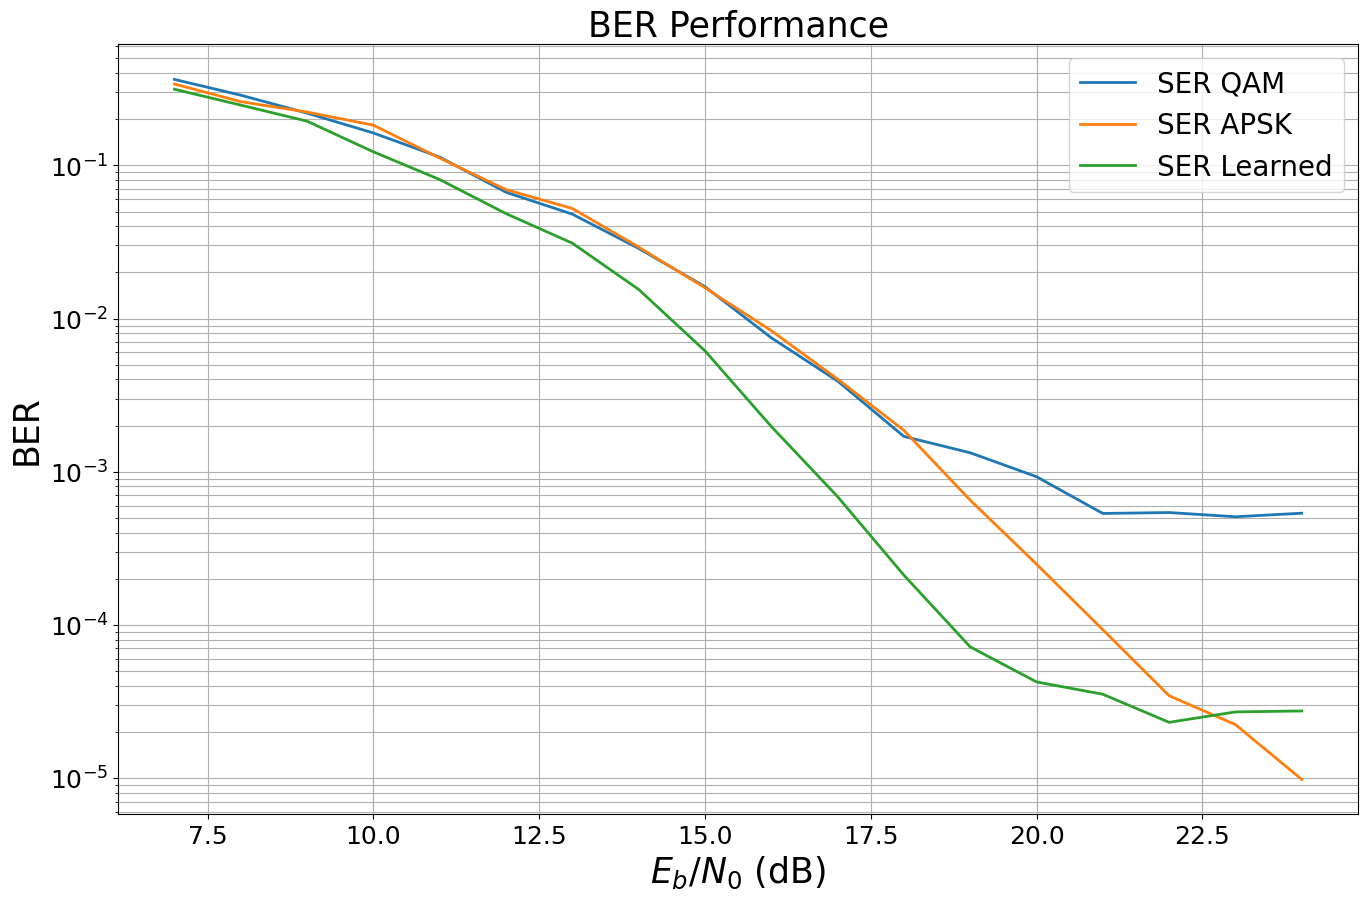

In [39]:
ber_plot_bicm.simulate(model, # the function have defined previously
                          ebno_dbs=np.arange(7.0, 25.0, 1), # sim SNR range
                          legend="SER Learned",
                          max_mc_iter=1000,
                          num_target_bit_errors=100,
                          batch_size=batch_size,
                          soft_estimates=False,
                          early_stop=True,
                          show_fig=True,
                          forward_keyboard_interrupt=False)

In [40]:
print(ber_plot_bicm.snr)
print(ber_plot_bicm.ber)

[array([ 7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.,
       20., 21., 22., 23., 24.]), array([ 7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.,
       20., 21., 22., 23., 24.]), array([ 7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.,
       20., 21., 22., 23., 24.])]
[<tf.Tensor: shape=(18,), dtype=float32, numpy=
array([0.36445314, 0.2875    , 0.21953125, 0.16289063, 0.11328125,
       0.06679688, 0.04804688, 0.02871094, 0.01614583, 0.00748698,
       0.00390625, 0.00169837, 0.00132813, 0.0009266 , 0.00053315,
       0.00054045, 0.00050731, 0.0005351 ], dtype=float32)>, <tf.Tensor: shape=(18,), dtype=float32, numpy=
array([3.4023437e-01, 2.6093751e-01, 2.2304687e-01, 1.8320313e-01,
       1.1171875e-01, 6.9531247e-02, 5.2343749e-02, 2.9296875e-02,
       1.5885416e-02, 8.3333338e-03, 4.0234374e-03, 1.8601191e-03,
       6.5104169e-04, 2.4880574e-04, 9.2785034e-05, 3.4375000e-05,
       2.2265625e-05, 9.7656248e-06], dtype=float32)>, <

In [22]:
snr_array = np.array([ 7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.,20., 21., 22., 23., 24.]) + 10*np.log(6.0)/np.log(10.0)

ser_apsk = np.array([3.4023437e-01, 2.6093751e-01, 2.2304687e-01, 1.8320313e-01,
       1.1171875e-01, 6.9531247e-02, 5.2343749e-02, 2.9296875e-02,
       1.5885416e-02, 8.3333338e-03, 4.0234374e-03, 1.8601191e-03,
       6.5104169e-04, 2.4880574e-04, 9.2785034e-05, 3.4375000e-05,
       2.2265625e-05, 9.7656248e-06])

ser_qam = np.array([0.36445314, 0.2875    , 0.21953125, 0.16289063, 0.11328125,
       0.06679688, 0.04804688, 0.02871094, 0.01614583, 0.00748698,
       0.00390625, 0.00169837, 0.00132813, 0.0009266 , 0.00053315,
       0.00054045, 0.00050731, 0.0005351 ])

ser_learned = np.array([3.1445312e-01, 2.4765626e-01, 1.9453125e-01, 1.2265625e-01,
       8.0859378e-02, 4.8437499e-02, 3.1054687e-02, 1.5494792e-02,
       6.1523439e-03, 1.9726562e-03, 6.8696123e-04, 2.1081349e-04,
       7.1674309e-05, 4.2321237e-05, 3.5156248e-05, 2.3046876e-05,
       2.6953125e-05, 2.7343751e-05])

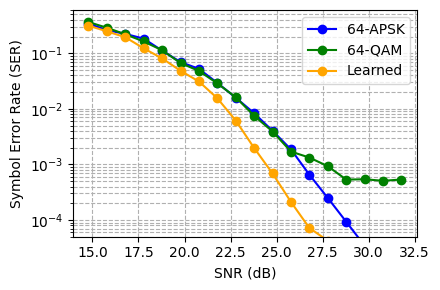

In [25]:
# Plotting
fig = plt.figure(figsize=(4.5, 3.0))
plt.semilogy(snr_array, ser_apsk, 'o-', label='64-APSK', color='blue')
plt.semilogy(snr_array, ser_qam, 'o-', label='64-QAM', color='green')
plt.semilogy(snr_array, ser_learned, 'o-', label='Learned', color='orange')

plt.grid(True, which='both', linestyle='--')
plt.xlabel('SNR (dB)')
plt.ylabel('Symbol Error Rate (SER)')
plt.ylim(5*10**(-5), 0.6)
# plt.title('BER vs. Eb/N0')
plt.legend()
plt.tight_layout()
plt.show()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      7.0 | 6.0820e-01 | 1.0000e+00 |        3114 |        5120 |           20 |          20 |        15.2 |reached target bit errors
      8.0 | 5.4180e-01 | 1.0000e+00 |        2774 |        5120 |           20 |          20 |         0.1 |reached target bit errors
      9.0 | 4.7031e-01 | 1.0000e+00 |        2408 |        5120 |           20 |          20 |         0.1 |reached target bit errors
     10.0 | 3.9746e-01 | 1.0000e+00 |        2035 |        5120 |           20 |          20 |         0.1 |reached target bit errors
     11.0 | 3.3574e-01 | 1.0000e+00 |        1719 |        5120 |           20 |          20 |         0.1 |reached target bit errors
     12.0 | 2.6719e-01 | 1.0000e+00 |        1368 |        5120 |          

(<tf.Tensor: shape=(23,), dtype=float32, numpy=
 array([6.0820311e-01, 5.4179686e-01, 4.7031251e-01, 3.9746094e-01,
        3.3574218e-01, 2.6718751e-01, 2.1914062e-01, 1.7011718e-01,
        1.1328125e-01, 7.8515626e-02, 5.1757812e-02, 3.3789061e-02,
        2.3242187e-02, 1.0937500e-02, 6.1523439e-03, 2.7099610e-03,
        1.3151042e-03, 3.8325472e-04, 1.9140624e-04, 8.5937500e-05,
        3.5156248e-05, 1.9531250e-05, 2.1484375e-05], dtype=float32)>,
 <tf.Tensor: shape=(23,), dtype=float32, numpy=
 array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.925     , 0.825     ,
        0.525     , 0.3       , 0.09528302, 0.0475    , 0.0205    ,
        0.009     , 0.0045    , 0.005     ], dtype=float32)>)

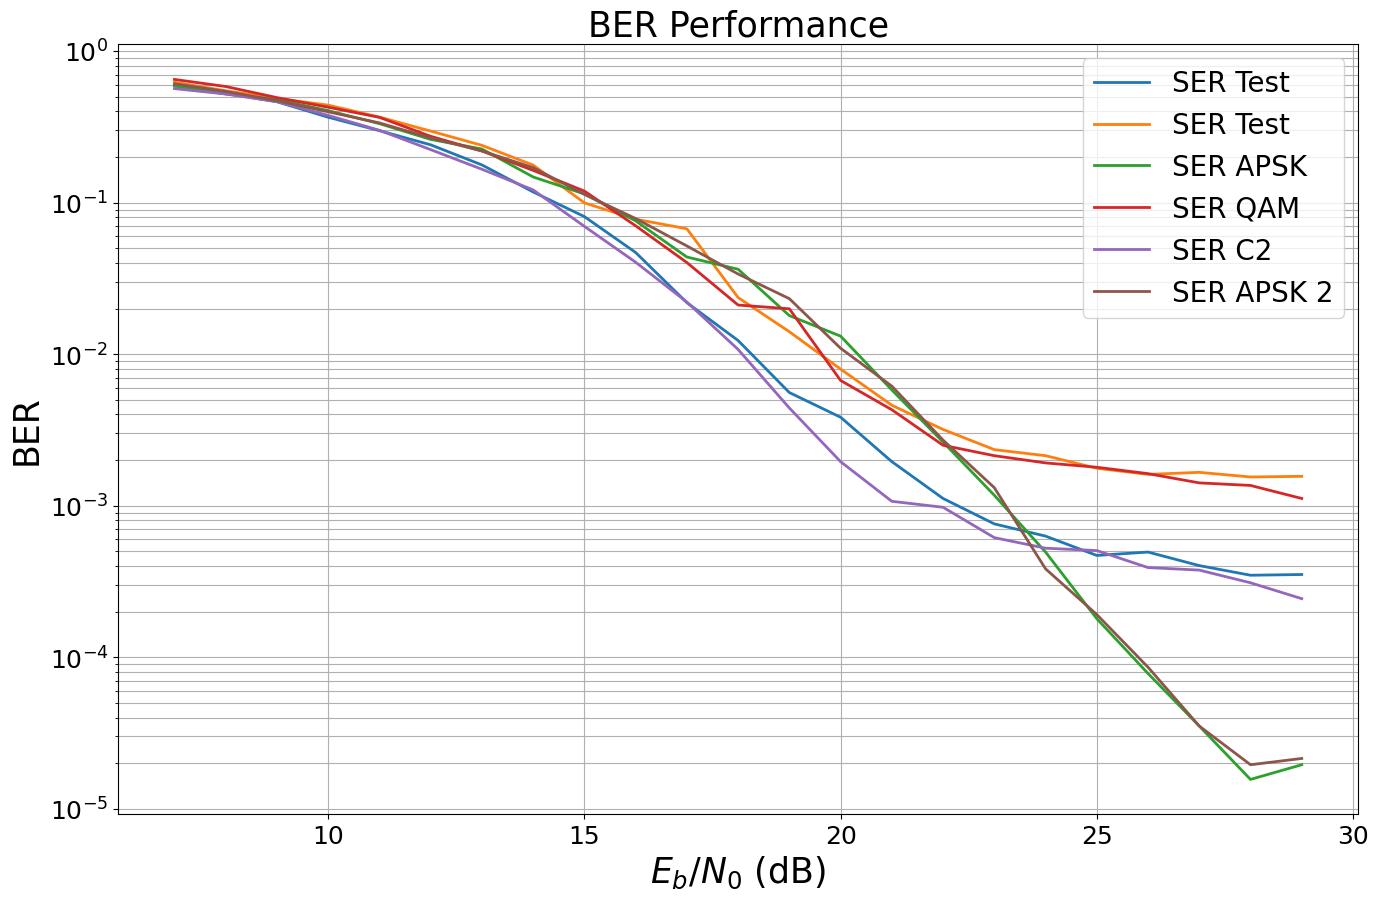

In [152]:
ber_plot_bicm.simulate(model, # the function have defined previously
                          ebno_dbs=np.arange(7.0, 30.0, 1), # sim SNR range
                          legend="SER APSK 2",
                          max_mc_iter=100,
                          num_target_bit_errors=100,
                          batch_size=batch_size,
                          soft_estimates=False,
                          early_stop=True,
                          show_fig=True,
                          forward_keyboard_interrupt=False)

In [57]:
def plot_constellation(points, plot_title):

    points = np.asarray(points)

    marker_sizes = 300

    plt.figure(figsize=(8, 8))
    plt.scatter(points.real, points.imag, s=marker_sizes, alpha=0.7, c='b', edgecolors='k')

    # Add grid and formatting
    plt.axhline(0, color='gray', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='gray', linewidth=0.5, linestyle='--')
    plt.grid(True, linestyle=':')
    plt.xlabel("In-phase")
    plt.ylabel("Quadrature")
    plt.title(plot_title)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    # plt.show()

In [66]:
with tf.GradientTape(persistent=False) as tape:
#     tape.watch(model.trainable_variables)  # Ensure variables are watched if needed, but no gradients will be calculated
#     ebno_db = tf.random.uniform(shape=[10], minval=28.0, maxval=29.0)
    ebno_db = tf.convert_to_tensor(np.array([8.0, 15.0, 22.0, 29.0, 8.0, 15.0, 22.0, 29.0, 8.0, 15.0])-0.781513)
    # No = sn.phy.utils.ebnodb2no(ebno_db, num_bits_per_symbol=num_bits_symbol, coderate=1)
    # No = tf.expand_dims(No, axis=-1)
    _, norm_const = model(batch_size = 10, ebno_db = ebno_db)



In [67]:
ebno_db.numpy() + 10*np.log(6.0)/np.log(10.0)

array([14.9999995, 21.9999995, 28.9999995, 35.9999995, 14.9999995,
       21.9999995, 28.9999995, 35.9999995, 14.9999995, 21.9999995])

In [68]:
# Define constellation points (complex numbers)
points0 = norm_const[0,0,0,:].numpy()
points1 = norm_const[1,0,0,:].numpy()
points2 = norm_const[2,0,0,:].numpy()
points3 = norm_const[3,0,0,:].numpy()

# title_plot = f"Normalized Constellation"
# Plot the constellation
# plot_constellation(points1, title_plot) # [3,0,0,:]


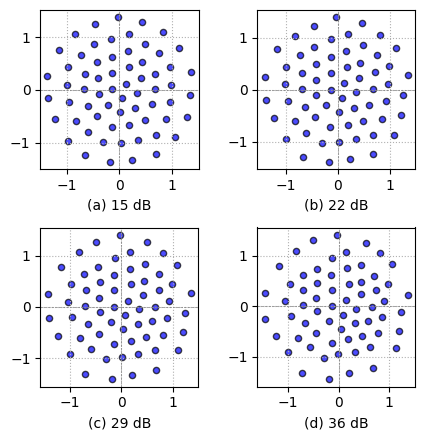

In [74]:
def plot_constellation_grid(points, plot_title, ax):
    points = np.asarray(points)
    marker_sizes = 20

    ax.scatter(points.real, points.imag,
               s=marker_sizes, alpha=0.7,
               c='b', edgecolors='k')

    # Formatting
    ax.axhline(0, color='gray', linewidth=0.5, linestyle='--')
    ax.axvline(0, color='gray', linewidth=0.5, linestyle='--')
    ax.grid(True, linestyle=':')
    ax.set_xlabel(plot_title, fontsize=10)
    # ax.set_ylabel("Quadrature")
    # ax.set_title(plot_title)
    ax.set_aspect('equal', adjustable='box')

fig, axs = plt.subplots(2, 2, figsize=(4.5, 4.5))

plot_constellation_grid(points0, "(a) 15 dB", axs[0, 0])
plot_constellation_grid(points1, "(b) 22 dB", axs[0, 1])
plot_constellation_grid(points2, "(c) 29 dB", axs[1, 0])
plot_constellation_grid(points3, "(d) 36 dB", axs[1, 1])

plt.tight_layout()
plt.show()

In [ ]:
# Define constellation points (complex numbers)
points = norm_const[0,0,0,:].numpy() # + 1j* norm_const.numpy()
y_norm_points = y_norm[0,:5].numpy() # + 1j* y_norm.numpy()
x_mod_points = x_mod[0,:5].numpy() # + 1j* x_mod.numpy()
# points = apsk_64_const
title_plot = f"Normalized Constellation"
# Plot the constellation
plot_constellation(points, title_plot) # [3,0,0,:]
plot_constellation(y_norm_points, title_plot)
plot_constellation(x_mod_points, title_plot)

print(points)

### Testing SNR specific Modulator and Demodulator

In [69]:
class Modulator_SNR(Layer):

    def __init__(self, N, constellation, **kwargs):
        super(Modulator_SNR,self).__init__(**kwargs)

        self.N = N
        # FC layers as requested
        self.dense1 = Dense(128, activation='relu')      # 128 ReLU
        self.dense2 = Dense(128, activation=None)        # 128 Linear
        self.dense_out = Dense(2 * N, activation=None)   # Final projection
        self.dense_out.build(input_shape=(None, 128))

        self.dense_out.set_weights([
            np.zeros((128, 2 * N), dtype=np.float32),np.concatenate([np.real(constellation), np.imag(constellation)],axis=0)
        ])

    def call(self, snr_db, s):

        # Pass SNR through FC layers
        x = self.dense1(snr_db)
        x = self.dense2(x)
        out = self.dense_out(x)

        # Split into real and imaginary parts
        real = out[:, :self.N]
        imag = out[:, self.N:]
        constellation = tf.complex(real, imag)

        # Normalize to unit average energy
        power = tf.reduce_mean(tf.abs(constellation)**2, axis=1, keepdims=True)
        print(power)
        print('constellation:',np.abs(constellation[0].numpy())**2)
        norm_constellation = constellation / tf.complex(tf.sqrt(power),0.0)

        # Expand the signal dimension to align for matrix multiplication
        s = tf.expand_dims(s, axis=-1)
        norm_constellation = tf.expand_dims(tf.expand_dims(norm_constellation, axis=[1]), axis=[1])

        # Compute the modulated signal
        x_real = tf.matmul(tf.math.real(norm_constellation), s)
        x_imag = tf.matmul(tf.math.imag(norm_constellation), s)
        x = tf.complex(x_real, x_imag)

        return tf.squeeze(x, axis=[-2, -1]), norm_constellation

class Demodulator_SNR(Layer):
    def __init__(self, N):
        super(Demodulator_SNR, self).__init__()
        self.dense1 = Dense(128, activation='relu')  # First Dense Layer
        self.dense2 = Dense(128, activation='relu')  # Second Dense Layer
        self.dense3 = Dense(N)                      # Output Dense Layer
        # self.snr_db = snr_db                        # SNR in dB
        # self.device = device                        # Device (e.g., "cpu", "gpu")

    def call(self, ebno_db, y):

        y = tf.expand_dims(y, axis=-1)
        ebno_db = tf.expand_dims(ebno_db, axis=1)
        # Ensure complex-valued input is split into real and imaginary parts
        y_real = tf.math.real(y)
        y_imag = tf.math.imag(y)

        # Create and broadcast SNR tensor
        # snr_tensor = tf.constant([[self.snr_db]], dtype=tf.float32)
        brd_ebno_db = tf.broadcast_to(ebno_db, [tf.shape(y_real)[0], tf.shape(y_real)[1], 1])

        # Concatenate real, imaginary, and SNR tensors along the last dimension
        stack_input = tf.concat([y_real, y_imag, brd_ebno_db], axis=2)

        # Pass the stacked input through the dense layers
        x = self.dense1(stack_input)
        x = self.dense2(x)
        logits = self.dense3(x)

        # Apply softmax to logits
        pred_probs = tf.nn.softmax(logits, axis=-1)

        return pred_probs

class AWGNDemodulator(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, y, N0, norm_constellation):

        y_exp = tf.expand_dims(y, axis=-1)
        const_exp = tf.reshape(norm_constellation, [y_exp.shape[0], 1, -1])
        dist2 = tf.abs(y_exp - const_exp) ** 2   # (B, T, N)
        log_probs = -dist2 / tf.expand_dims(N0, axis=1)
        p_xy = tf.nn.softmax(log_probs, axis=-1)

        return p_xy

In [70]:
modulator_test = Modulator_SNR(64,constellation)
demodulator_test = Demodulator_SNR(64)
demod_awgn = AWGNDemodulator()
channel_awgn = sn.phy.channel.AWGN()
symbol_index_seq = tf.random.uniform(shape=(3,7), minval=0, maxval=64, dtype=tf.int32)
s = tf.one_hot(symbol_index_seq, depth=64, dtype=tf.float32)
ebno_db = tf.expand_dims(tf.random.uniform(shape=[3], minval=10.0, maxval=12.0),axis = 1)
No = sn.phy.utils.ebnodb2no(ebno_db, num_bits_per_symbol=6, coderate=1)
x_mod, norm_const = modulator_test(ebno_db,s)
y_channel = channel_awgn(x_mod, No)
# demod_out = demodulator_test(ebno_db, y_channel)

demod_out_awgn = demod_awgn(y_channel, No, norm_const)

Tensor("Mean:0", shape=(3, 1), dtype=float32)
tf.Tensor(
[[1.]
 [1.]
 [1.]], shape=(3, 1), dtype=float32)
constellation: [0.07228047 0.07228045 0.07228047 0.07228045 0.07228047 0.07228045
 0.07228047 0.07228045 0.3498374  0.34983733 0.3498374  0.3498374
 0.3498374  0.34983733 0.3498374  0.3498374  0.3498374  0.34983733
 0.3498374  0.3498374  0.3498374  0.34983733 0.3498374  0.3498374
 0.9367547  0.9367546  0.9367546  0.9367546  0.9367547  0.9367547
 0.9367546  0.9367546  0.9367546  0.9367547  0.9367547  0.9367546
 0.9367546  0.9367546  0.9367547  0.9367547  0.9367546  0.9367546
 0.9367546  0.9367547  1.9544634  1.9544634  1.9544634  1.9544634
 1.9544634  1.9544634  1.9544634  1.9544634  1.9544634  1.9544634
 1.9544634  1.9544634  1.9544634  1.9544634  1.9544634  1.9544634
 1.9544634  1.9544634  1.9544634  1.9544634 ]
